# INF8111 - Fouille de données


## TP1 Été 2024 - Duplicate Bug Report Detection

##### Date de remise: 19/05 à 23:55

##### La note TP sera pénalisée de 10 points si le notebook met plus d'1h à s'exécuter. 



#### Membres de l'équipe:

    - Nicolas Depelteau (2083544)
    
##### Deliverables:

Vous devez soumettre deux fichiers distincts sur Moodle: 
1. Ce notebook
2. Un [Json](https://en.wikipedia.org/wiki/JSON) contenant du contenu de page Web récupéré (bug_reports.json) 
    


## Résumé

En raison de la complexité des systèmes logiciels, les bogues logiciels sont répandus. Les entreprises, en particulier les grandes, utilisent généralement un système de suivi des bogues (BTS), également appelé système de suivi des problèmes, pour gérer et suivre les enregistrements des bogues. Outre les développeurs et les testeurs, de nombreux projets, principalement des projets open source, permettent aux utilisateurs de signaler de nouveaux bogues dans leur BTS. Pour ce faire, les utilisateurs doivent remplir un formulaire avec plusieurs champs. Un sous-ensemble important de ces champs fournissent des données catégorielles et n'acceptent que les valeurs d'une liste fixe d’options (par exemple, composant, version et produit du système). Deux autres domaines importants sont le résumé et la description. Les utilisateurs sont libres d'écrire ce qu'ils veulent dans ces deux champs avec la seule contrainte que le résumé ne dépasse pas un nombre maximal de caractères. La soumission d'un formulaire crée une page, appelée rapport de bogue ou rapport de problème, qui contient toutes les informations sur un bogue.

En raison du manque de communication et de synchronisation, les utilisateurs peuvent ne pas savoir qu'un bogue spécifique a déjà été soumis et le signalent à nouveau. Identifier les rapports de bogues en double est une tâche importante dans les BTS et c'est le sujet de ce TP. Fondamentalement, notre objectif est de développer un système qui prédit si une paire de nouveau rapport de bogue et un rapport de bogue soumis sont dupliqué ou non. Ce système sera utilisé pour identifier manuellement les rapports dupliqué.

# 2 Prérequis

Pour ce TP, vous aurez besoin des librairies `numpy` et `sklearn`, ainsi que la librairie `nltk`, qui est une libraire utilisée pour faire du traitement du language (Natural Language Processing, NLP)

Installez les libraires en question et exécutez le code ci-dessous :

In [ ]:
# If you want, you can use anaconda and install after nltk library
!pip install --user numpy
!pip install --user scikit-learn
!pip install --user nltk
!pip install --user bs4

#python
import nltk
nltk.download("punkt")
from IPython import display
display.clear_output()

# 3 - Les données

Téléchargez l'archive à l'adresse suivante: https://www.dropbox.com/s/s53fqz29z8ch4ip/data.zip?dl=0

L'archive contient: 

1. training.txt : ce fichier contient des paires de rapports de bogues qui seront utilisés pour entraîner notre système.
2. validation.txt : Ce fichier contient des paires de rapports de bogues qui seront utilisés pour évaluer notre système.
2. bug_reports : Ce dossier contient le code HTML des rapports de bogues. Chaque fichier HTML est nommé selon le motif **bug_report_id.html**.


L'image ci-dessous illustre un exemple de bug report:



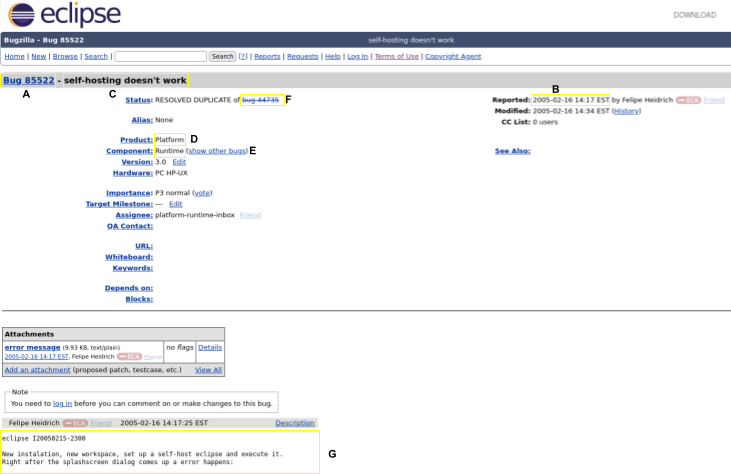

In [2]:
from IPython import display
!rm -rf data.zip data
!gdown 12z5OddTOEn7hnQFaHh9qwrbVJTnqtDq-
!unzip data.zip
!rm -rf data.zip
display.clear_output()
display.Image("https://irving-muller.github.io/images/bug-report-eclipse.png")

- A : identifiant du bug report
- B : date de création
- C : résumé
- D : produit
- E : composant
- F : l'identifiant du rapport dont le bug report est dupliqué
- G : description


Le script suivant charge le jeu de données de test et définit certaines variables globales:

In [3]:
import os

# définir le chemin du dossier qui contient les données 
FOLDER_PATH = "data/"
PAGE_FOLDER = os.path.join(FOLDER_PATH, 'bug_reports')


# Charger l'ensemble de données d'évaluation 
import json


training_file = open(os.path.join(FOLDER_PATH, "training.txt"))
validation_file = open(os.path.join(FOLDER_PATH, "validation.txt"))
word_vec_path = os.path.join(FOLDER_PATH, "glove.42B.300d_clear.txt")

def read_dataset(f):
    for line in f:
        line = line.strip()
        
        if len(line) == 0:
            continue
        
        rep1, rep2, label = line.split(',')

        rep1 = int(rep1)
        rep2 = int(rep2)
        label = 1.0 if int(label) > 0 else 0.0 
        
        yield (rep1, rep2, label)
    
    


training_pairs = list(read_dataset(training_file))
validation_pairs = list(read_dataset(validation_file))

training_reports_set = set()


for r1, r2, _ in training_pairs:
    training_reports_set.add(r1)
    training_reports_set.add(r2)

# 4 - Web scraping

"Le *web scraping* (parfois appelé harvesting) est une technique d'extraction du contenu de sites Web, via un script ou un programme, dans le but de le transformer pour permettre son utilisation dans un autre contexte, par exemple le référencement." [Wikipedia](https://fr.wikipedia.org/wiki/Web_scraping)


## 4.1 - Question 1 (4 points)

Implémentez la fonction *extract_data_from_page* qui extrait les informations suivantes du code HTML: l'ID du bug report, la date de création, le titre, le produit, le composant, l'ID du bug report dont il est un duplicata, et la description.

La fonction *extract_data_from_page* retourne un dictionnaire avec la structure suivante:

```python
 {"report_id": int, 
  "dup_id": int or None (the report id which it is duplicate), 
  "component": string, 
  "product": string, 
  "summary": string, 
  "description": string, 
  "creation_date": string} 
```

Par exemple, pour le bug report "bug_report/18431.html", la fonction *extract_data_from_page* retourne:
 
```python
{'report_id': 18431,
 'dup_id': 27227,
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polyline polyline2 = new Polyline();\n polyline2.setStart(new Point( 5, 5));\n polyline2.addPoint(new Point( 45, 45));\n panel.add(polyline2);\n\n Display display = Display.getDefault();\n while( !shell.isDisposed() )\n {\n  if( !display.readAndDispatch() )\n   display.sleep();\n }\n\n}',
 'creation_date': '2002-05-31 09:17 EDT'}
```

**La date de création doit être représentée sous la forme d'un "année-mois-jour heure:minute fuseau horaire". Si un bug report n'est pas un duplicata, alors dup_id doit être None.**

*Indice: lxml parse est plus rapide que html.parser*

In [9]:
from bs4 import BeautifulSoup
import re

def extract_data_from_page(pagepath, page_html=None):
    """
    Scrap le contenu du rapport de html 
    
    :param pagepath: le chemin du fichier html. 
    :return: 
        {
        "report_id": int,
        "dup_id": int or None (l'identifiant du rapport dont il est dupliqué), 
        "component": string, 
        "product": string, 
        "summary": string, 
        "description": string, 
        "creation_date": string
        }
    """
    
    if page_html is None:
        with open(pagepath, 'r') as f:
            page_html = f.read()
            
    soup = None
    report_id = None
    dup_id = None
    component = None
    product = None
    summary = None
    description = None
    creation_date = None
    
    soup = BeautifulSoup(page_html, 'lxml')

    report = soup.find("div", class_="bz_short_desc_container")
    if report is not None:
        link = report.find("a")
        if link is not None:
            report_id = re.search(r"\d+", link.get_text(strip=True))
            if report_id is not None:
                report_id = report_id.group()
    
    dup = soup.find(id="static_bug_status")
    if dup is not None:
        dup_id = re.search(r"(\d+)", dup.getText())
        if dup_id is not None:
            dup_id = dup_id.group()
    
    component = soup.find(id="field_container_component")
    if component is not None:
        component = component.getText().strip()
        if component is not None:
            component = re.search(r"^([\w\s-]+)", component)
            if component is not None:
                component = component.group().strip()

    product = soup.find(id="field_container_product")
    if product is not None:
        product = product.getText().strip()
    
    summary = soup.find(id="short_desc_nonedit_display")
    if summary is not None:
        summary = summary.getText(strip=True)
    
    description = soup.find(class_="bz_comment_text")
    if description is not None:
        description = description.getText(strip=True)

    creation_date = soup.find(id="bz_show_bug_column_2")
    if creation_date is not None:
        creation_date = creation_date.find('th', string=re.compile(r'Reported:', re.IGNORECASE))
        if creation_date is not None:
            creation_date = creation_date.find_next_sibling('td')
            if creation_date is not None:
                creation_date = re.search(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}) (\w+)', creation_date.get_text(strip=True))
                if creation_date is not None:
                    creation_date = creation_date.group()
    
    return {
        "report_id": report_id,
        "dup_id": dup_id,
        "component": component,
        "product": product,
        "summary": summary,
        "description": description,
        "creation_date": creation_date
    }

exemple_report = extract_data_from_page("data/bug_reports/18431.html")
exemple_report

{'report_id': '18431',
 'dup_id': '27227',
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polylin

## 4.3 - Extraction du texte depuis le HTML


In [ ]:
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from time import time
import json
from tqdm.autonotebook import tqdm
import typing as tp

# Indexer chaque rapport par son identifiant 
index_path = os.path.join(FOLDER_PATH, 'bug_reports.json')

if os.path.isfile(index_path):
    report_index = json.load(open(index_path))
else:
    # Extraire le contenu d'une page Web 
    
    # Cela peut être lent (environ 15 minutes). Testez votre code avec un petit échantillon. l'analyse lxml est plus rapide que html.parser
    files = [os.path.join(PAGE_FOLDER, filename) for filename in os.listdir(PAGE_FOLDER)]
    reports = [extract_data_from_page(f) for f in tqdm(files)]
    report_index = dict(((report['report_id'], report) for report in reports ))

    # Save preprocessed bug reports
    json.dump(report_index, open(index_path,'w'))


# 5 - Prétraitement des données

Le prétraitement des données est une tache cruciale en fouille de données. Cette étape nettoie et transforme les données brutes dans un format qui permet leur analyse, et leur utilisation avec des algorithmes de *machine learning*. En traitement des langages (natural language processing, NLP), la *tokenization* et le *stemming* sont des étapes cruciales. De plus, vous implémenterez une étape supplémentaire pour filtrer les mots sans importance.

## 5.1 - Tokenization

Cette étape permet de séparer un texte en séquence de *tokens* (= jetons, ici des mots, symboles ou ponctuation).

Par exemple, la phrase "It's the student's notebook." peut être séparé en liste de tokens de cette manière: ["it", " 's", "the", "student", " 's", "notebook", "."].


### 5.1.1 - Question 2 (1 point) 

**Implementez** ```tokenize_space_punk``` **qui remplace la ponctuation par un espace, puis tokenise les jetons séparés par des espaces (espace, tabulation, nouvelle ligne). Tous les tokenizers doivent mettre les jetons en minuscule.***

In [11]:
import re
import typing as tp

def tokenize_space_punk(text:str) -> tp.List[str]:
    """
    This tokenizer replaces punctuation to spaces and then tokenizes the tokens that are separated by whitespace (space, tab, newline).
    """
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = re.split(r'\s+', text)
    tokens = [token.lower() for token in tokens if token.strip()]
    return tokens


sentence = "It's the student's notebook."
tokens = tokenize_space_punk(sentence)
print(tokens)

['it', 's', 'the', 'student', 's', 'notebook']


## 5.2 - Stop words removal

### 5.2.1 - Question 3 (0.5 point)

Certains tokens sont sans importance pour la comparaison, car ils apparaissent dans la majorité des discussions. Les supprimer réduit la dimension du vecteur et accélère les calculs.

Expliquez quels tokens sont sans importances pour la comparaison des discussions. Implémentez la fonction filter_tokens qui retire ces mots de la liste des tokens.

*Vous pouvez utiliser un ensemble de mots prédéfini.* 

In [13]:
import nltk
from nltk.corpus import stopwords
import typing as tp
nltk.download('stopwords')

def filter_tokens(tokens:tp.List[str]) -> tp.List[str]:
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens


tokens = ['it', 's', 'the', 'student', 's', 'notebook']
filtered_tokens = filter_tokens(tokens)
print(filtered_tokens)

['student', 'notebook']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 5.3 - Stemming

La racinisation (stemming) est un procédé de transformation des flexions en leur radical ou racine. Par example, en anglais, la racinisation de "fishing", "fished" and "fish" donne "fish" (stem). 


In [14]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')


word1 = ['I', 'tried', 'different', 'fishes']

print([ stemmer.stem(w) for w in word1])

word2 = ['I', 'will', 'tries', 'only', 'one', 'fishing']
print([ stemmer.stem(w) for w in word2])

['i', 'tri', 'differ', 'fish']
['i', 'will', 'tri', 'onli', 'one', 'fish']


### 5.3.1 - Question 4 (0.5 point) 

Expliquez comment le stemming peut améliorer notre système des données

# 6 - Représentation des données


# 6.1 - Bag of Words (BoW)

De nombreux algorithmes demandent des entrées qui sont toutes de la même taille. Cela n'est pas toujours le cas, notamment pour des données textuelles qui peuvent avoir un nombre variable de mots. 

Par exemple, considérons la phrase 1, ”Board games are much better than video games” et la phrase 2, ”Monopoly is an awesome game!” La table ci-dessous montre un exemple d'un moyen de représentation de ces deux phrases en utilisant une représentation fixe : 

|            | an | are | ! | monopoly | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 0 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |


Chaque colonne représente un mot du vocabulaire (de tailler 13), tandis que chaque ligne contient l'occurrence des mots dans une phrase. Ainsi, la valeur 2 à la position (1,7) est due au mot *"games"* qui apparaît deux fois dans la phrase 1. 

Ainsi, chaque ligne étant de longueur 13, on peut les utiliser comme vecteur pour représenter les phrases 1 et 2. Ainsi, c'est cette méthode que l'on appelle *Bag-of-Words* : c'est une représentation de documents par des vecteurs dont la dimension est égale à la taille du vocabulaire, et qui est construite en comptant le nombre d'occurrences de chaque mot. Ainsi, chaque token est ici associé à une dimension.

*Pour plus de simplicité, nous considérons le token et le mot comme interchangeables.**


## 6.2 - TF-IDF


L'utilisation de la fréquence brute d'apparition des mots, comme c'est le cas avec bag-of-words, peut être problématique. En effet, peu de tokens auront une fréquence très élevée dans un document, et de ce fait, le poids de ces mots sera beaucoup plus grand que les autres, ce qui aura tendance à biaiser l'ensemble des poids ([Zipf law](https://en.wikipedia.org/wiki/Zipf%27s_law)). De plus, les mots qui apparaissent dans la plupart des documents n'aident pas à les discriminer. Par exemple, le mot "*de*" apparaît dans beaucoup de documents de la base de données, pour autant, avoir ce mot en commun ne permet pas de conclure que des documents sont similaires. À l’inverse, le mot "*génial*" est plus rare, mais les documents qui contiennent ce mot sont plus susceptibles d'être positifs. TF-IDF est donc une méthode qui permet de pallier à ce problème.

TF-IDF pondère le vecteur en utilisant une fréquence de document inverse (IDF) et une fréquence de termes (TF).

TF est l'information locale sur l'importance qu'a un mot dans un document donné, tandis que IDF mesure la capacité de discrimination des mots dans un jeu de données. 

L'IDF d'un mot se calcule de la façon suivante:
\begin{equation}
	\operatorname{IDF}(t) = \ln\left( \frac{N+1}{\operatorname{df}(t)+1} \right) + 1,
\end{equation}
où $t$ est un token, $N$ est le nombre de documents dans l'ensemble de données, et $\operatorname{df}(\cdot)$  est le nombre de documents qui contiennent un mot $i$.

Le nouveau poids d'un mot $t$ dans un texte peut ensuite être calculé de la façon suivante:

\begin{equation}
	w(t) = \operatorname{tf}(t) \times \operatorname{IDF}(t),
\end{equation}
où $\operatorname{tf}(\cdot)$ est le fréquence du mot 𝑖 dans le document 𝑗, c'est-à-dire le nombre de fois qu'un mot apparaît dans le document. *Nous appelons représentation TF-IDF lorsque les poids de la représentation BoW sont calculés au moyen de TF-IDF.*

*Dans ce TP, nous représentons chaque texte comme une liste de tuples dans laquelle le tuple est composé du token et de son poids calculé par TF-IDF. Pour améliorer l'efficacité, nous trions les tuples par token. Ainsi, par exemple, la phrase 1 du tableau précédent est représentée comme suit : ```[ ("are", 1.4054), ("better", 1.4054), ("board", 1.4054), ("games", 2.8108), ("much", 1.4054), ("than", 1.4054), ("video", 1.4054)]```.*


### 6.2.1 - Question 5 (3.5 points)

**Maintenant, vous devez implémenter TF-IDF. La méthode** ```fit``` **calcule IDF sur la base des données textuelles dans X et la méthode** ```transform``` **transforme un texte en une représentation TF-IDF.**

*Remarques*:

- Attention à ce que ```transform``` puisse recevoir des tokens qui n'étaient pas dans X. Dans ce cas, considérez que $\operatorname{df}(\cdot)=0$.
- Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn sauf numpy.

In [15]:
import numpy as np
import typing as tp

class TFIDF:
    
    def __init__(self):
        self.idf_values: tp.Dict[str, float]  = {}
    
    def fit(self, X: tp.List[tp.List[str]]):
        """
        Apprendre les valeurs IDF basées sur les données textuelles dans X
        
        X:  liste des listes de tokens. Par example, X=[['video','awesome', 'The'], ['house', 'The']] 

        :return: None
        """
        N = len(X)
        doc_freq: tp.Dict[str, int] = {}
        for tokens in X:
            unique_tokens = set(tokens)
            for token in unique_tokens:
                doc_freq[token] = doc_freq.get(token, 0) + 1
        
        self.idf_values = {}
        for token, freq in doc_freq.items():
            self.idf_values[token] = np.log((N + 1) / (freq + 1)) + 1
            
              

    def transform(self, tokens: tp.List[str]) -> tp.List[tp.Tuple[str, float]]:
        """
        Transforme un texte en une représentation TF-IDF
        
        tokens: liste de tokens.Par example, tokens=['video','awesome', 'The', 'The']
        
        :return: list of lists of tuples. Renvoie la représentation TF-IDF des textes.  
                Par example, [('video', 1.4054), ('awesome', 1.4054), ('The', 2.0)]
        """
        tf_values: tp.Dict[str, int] = {}
        for token in tokens:
            tf_values[token] = tf_values.get(token, 0) + 1
        
        tf_idf_representation = []
        for token, tf in tf_values.items():
            idf = self.idf_values.get(token, 0)
            tf_idf_representation.append((token, tf * idf))
        return tf_idf_representation
    

## 6.3 - Word embedding

Récemment, un nouveau type de représentation, appelé word embedding ou word vector, s'est révélé très utile pour la NLP. Dans les word embeddings, les mots sont représentés comme des vecteurs réels, de faible dimension et denses. Ces vecteurs décrivent les positions des mots dans un nouvel espace de caractéristiques qui conservent les informations syntaxiques et sémantiques. Contrairement à d'autres représentations, word embeddings limite la malédiction de la dimensionnalité et améliorent la capacité du modèle à gérer les mots inconnus et rares. Par ailleurs,
en utilisant word embedding, il est possible d'effectuer des opérations arithmétiques et
calculer la distance entre les mots. 
 

### 6.3.1 - Question 6 (3 points)

Dans ce TP, nous utiliserons des incorporations de mots pour générer une représentation dense du texte, appelée *text embedding*.
Dans ce contexte, le texte peut contenir une phrase ou plusieurs paragraphes.
Le text embedding est calculé comme la moyenne des vecteurs des mots :
\begin{equation}
	e_s = \frac{1}{|s|} \sum_{t \in s} w_t,
\end{equation}
où $|s|$ est la longueur du texte $s$, $w_t$ est word embedding du token $t$ dans $s$ et $e_s$ est le text embedding de $s$.

Vous utiliserez les vecteur des mots pré-entraînées de *glove.42B.300d_clear.txt* dans le dossier *dataset*.
Dans chaque ligne de ce fichier texte, il y a les tokens et leurs valeurs vectorielles. Les valeurs et les tokens sont séparés par des espaces. Dans ce fichier, la longueur de word embedding est de 300.


**Maintenant, vous devez implémenter la méthode** ```generate_embedding``` **qui génère les text embeddings. L'attribut token2vec est un dictionnaire qui relie un mot à son vecteur.**


*Remarques:*

- Ne pas tenir compte des mots qui n'existent pas dans glove.42B.300d_clear.txt
- Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn sauf numpy.

In [16]:
import numpy as np
import typing as tp

class TextEmbedding:
    
    def __init__(self):
        word_vec_file = open(word_vec_path)
        self.token2vec: tp.Dict[str, np.ndarray] = {}
        
        #TODO: load the file content
        with open(word_vec_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.array([float(x) for x in values[1:]], dtype=np.float32)
                self.token2vec[word] = vector
        self.embeding_size = self.token2vec['the'].shape[0]
    

    def generate_embedding(self, tokens: tp.List[str]) -> np.ndarray:
        """

        Générez text embedding en tant que moyenne de word embeddings dans tokens. 
        
        Ne pas tenir compte des mots qui n'existent pas dans glove.42B.300d_clear.txt

        tokens: liste de tokens.Par example, ["are", "better", "board", "much"]

        :return:  text embedding (numpy ou liste de nombres réels)
        """
        embedding = np.zeros(self.embeding_size)
        if len(tokens) == 0:
            return embedding
        for token in tokens:
            if token in self.token2vec:
                embedding += self.token2vec[token]
        embedding /= len(tokens)
        
        return embedding

# 7 - Pipeline

La *pipeline* est la séquence d'étapes de prétraitement des données qui transforme les données brutes dans un format qui permet leur analyse.



## 7.1 - Question 7 (2 points) 

**Maintenant, vous devez implémenter le pipeline en suivant les instructions dans les cellules ci-dessous.**


In [17]:
import numpy as np
import typing as tp




"""

Après l'exécution du pipeline, chaque rapport dans report_index doit contenir quatre clés :
     - summary_tfidf : représentation TF-IDF du résumé
     - desc_tfidf : représentation TF-IDF de la description
     - summary_vec : le text embedding du résumé
     - desc_vec : le text embedding  de la description

Par exemple, le rapport 18431 dans report_index (report_index[18431]) est : 

{'report_id': 18431,
 'dup_id': 27227,
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polyline polyline2 = new Polyline();\n polyline2.setStart(new Point( 5, 5));\n polyline2.addPoint(new Point( 45, 45));\n panel.add(polyline2);\n\n Display display = Display.getDefault();\n while( !shell.isDisposed() )\n {\n  if( !display.readAndDispatch() )\n   display.sleep();\n }\n\n}',
 'creation_date': '2002-05-31 09:17 EDT',
 'summary_vec': array([x.xxxxx, x.xxxxx, ... ]),
 'desc_vec':  array([x.xxxxx, x.xxxxx, ... ]),
 'summary_tfidf': [['flowlayout', x], ['ignor', x], ['polylin', x]],
 'desc_tfidf': [['2', x], ['45', x], ['5', x], ['add', x], ['addpoint', x], ... ]}

"""

"""
Étape 1. Tokeniser et supprimer les mots vides dans le résumé et la description de chaque rapport.
"""
#TODO: mettre en œuvre l'étape 1 

def pipeline_step_1(report:tp.Dict[str, tp.Any], *, key_in:str, key_out:str) -> tp.Dict[str, tp.Any]:
     tokens = tokenize_space_punk(report[key_in])
     tokens = filter_tokens(tokens)
     report[key_out] = tokens
     return report
    
exemple_report_step_1 = pipeline_step_1(exemple_report, key_in="summary", key_out="summary_tokens")
exemple_report_step_1 = pipeline_step_1(exemple_report, key_in="description", key_out="description_tokens")
exemple_report_step_1.keys()

dict_keys(['report_id', 'dup_id', 'component', 'product', 'summary', 'description', 'creation_date', 'summary_tokens', 'description_tokens'])

In [18]:

"""
Étape 2 . Générez les text embedding du résumé et de la description pour chaque rapport.
Utilisez les textes prétraités à l'étape 1 pour générer les embeddings.
"""

#TODO: mettre en œuvre l'étape 2 
def pipeline_step_2(report:tp.Dict[str, tp.Any], *, key_in:str, key_out:str, text_embedding:TextEmbedding) -> tp.Dict[str, tp.Any]:
     embedding = text_embedding.generate_embedding(report[key_in])
     report[key_out] = embedding
     return report
    
text_embedding = TextEmbedding()
exemple_report_step_2 = pipeline_step_2(exemple_report_step_1, key_in="summary_tokens", key_out="summary_vec", text_embedding=text_embedding)
exemple_report_step_2 = pipeline_step_2(exemple_report_step_1, key_in="description_tokens", key_out="desc_vec", text_embedding=text_embedding)
exemple_report_step_2

{'report_id': '18431',
 'dup_id': '27227',
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polylin

In [19]:
"""
Étape 3. Appliquez le stemming aux jetons générés à partir de l'étape 1.
"""
#TODO : mettre en œuvre l'étape 3
from nltk.stem.snowball import SnowballStemmer

def pipeline_step_3(report:tp.Dict[str, tp.Any], *, key_in:str, key_out:str, steamer:SnowballStemmer) -> tp.Dict[str, tp.Any]:
     tokens = report[key_in]
     steamed_tokens = [steamer.stem(token) for token in tokens]
     report[key_out] = steamed_tokens
     return report
    
steamer = SnowballStemmer('english')
exemple_report_step_3 = pipeline_step_3(exemple_report_step_2, key_in="summary_tokens", key_out="summary_steamed_tokens", steamer=steamer)
exemple_report_step_3 = pipeline_step_3(exemple_report_step_2, key_in="description_tokens", key_out="description_steamed_tokens", steamer=steamer)
exemple_report_step_3.keys()

dict_keys(['report_id', 'dup_id', 'component', 'product', 'summary', 'description', 'creation_date', 'summary_tokens', 'description_tokens', 'summary_vec', 'desc_vec', 'summary_steamed_tokens', 'description_steamed_tokens'])

In [20]:
"""
Étape 4. Apprenez l'IDF en utilisant le résumé et la description de tous les rapports dans le ensemble d'entraînement.
Vous devez concaténer le contenu de ces deux champs et un rapport sera considéré comme un document afin de calculer la fréquence des documents.
L'entrée de cette étape doit être la sortie de l'étape 3 (stemmed tokens).
"""
# training_reports_set contient tous les rapports de l'ensemble d'entraînement.
training_reports_set
    
# TODO: mettre en œuvre l'étape 4
def pipeline_step_4(reports: tp.List[tp.Dict], *, keys_in:tp.List[str]) -> TFIDF:
    tfidf_model = TFIDF()
    all_stemmed_tokens = []
    for report in reports:
        concatenated_tokens = []
        for key in keys_in:
            concatenated_tokens.extend(report[key])
        all_stemmed_tokens.append(concatenated_tokens)
    
    tfidf_model.fit(all_stemmed_tokens)
    return tfidf_model

tfidf_model = pipeline_step_4([exemple_report_step_3], keys_in=["summary_steamed_tokens", "description_steamed_tokens"])


In [21]:
"""
Étape 5. Générez la représentation TF-IDF du résumé et de la description pour chaque rapport.
L'entrée de cette étape doit être la sortie de l'étape 3 (stemmed tokens).
"""
#TODO : mettre en œuvre l'étape 5

def pipeline_step_5(report:tp.Dict[str, tp.Any], *, key_in:str, key_out:str, tfidf_model:TFIDF) -> tp.Dict[str, tp.Any]:
     tokens = report[key_in]
     tf_idf = tfidf_model.transform(tokens)
     report[key_out] = tf_idf
     return report

exemple_report_step_5 = pipeline_step_5(exemple_report_step_3, key_in="summary_steamed_tokens", key_out="summary_tfidf", tfidf_model=tfidf_model)
exemple_report_step_5 = pipeline_step_5(exemple_report_step_3, key_in="description_steamed_tokens", key_out="desc_tfidf", tfidf_model=tfidf_model)
exemple_report_step_5

{'report_id': '18431',
 'dup_id': '27227',
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polylin

In [22]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.autonotebook import tqdm
import os
import pickle

preprocessed_index_path = os.path.join(FOLDER_PATH, 'bug_reports_preprocessed.pkl')

if os.path.isfile(preprocessed_index_path):
    with open(preprocessed_index_path, 'rb') as f:
        report_index = pickle.load(f)
if os.path.isfile(preprocessed_index_path):
    report_index = json.load(open(preprocessed_index_path))
elif os.path.isfile(index_path):
    report_index = json.load(open(index_path))
else:
    print("Preprocessed bug reports file does not exist.")


def execute_pipeline_step(report_id, report:tp.Dict, pipeline_step, **kwargs):
    return {report_id: pipeline_step(report, **kwargs)}

def execute_parrelle_pipeline_step(report_index:tp.Dict[int, tp.Dict], pipeline_step, **kwargs):
    with ThreadPoolExecutor() as executor:
        futures = []
        for report_id, report in report_index.items():
            
            futures.append(executor.submit(execute_pipeline_step, report_id, report.copy(), pipeline_step, **kwargs))
    return futures

def execute_step(name:str, pipeline_step:callable, report_index:tp.Dict, **kwargs)->tp.Dict:
    futures = execute_parrelle_pipeline_step(report_index, pipeline_step, **kwargs)
    for future in tqdm(as_completed(futures), desc=name, total=len(report_index), position=1):
        result = future.result()
        report_index.update(result)
    return report_index

pipeline_progress_bar = tqdm(total=5, desc="Pipeline")

# Execute pipeline steps 1, 2, and 3 in parallel
report_index = execute_step("Step 1", pipeline_step_1, report_index, key_in="summary", key_out="summary")
report_index = execute_step("Step 1", pipeline_step_1, report_index, key_in="description", key_out="description")
pipeline_progress_bar.update(1)
text_embedding = TextEmbedding()
report_index = execute_step("Step 2", pipeline_step_2, report_index, key_in="summary", key_out="summary_vec", text_embedding=text_embedding)
report_index = execute_step("Step 2", pipeline_step_2, report_index, key_in="description", key_out="desc_vec", text_embedding=text_embedding)
steamer = SnowballStemmer('english')
pipeline_progress_bar.update(1)
report_index = execute_step("Step 3", pipeline_step_3, report_index, key_in="summary", key_out="summary", steamer=steamer)
report_index = execute_step("Step 3", pipeline_step_3, report_index, key_in="description", key_out="description", steamer=steamer)
pipeline_progress_bar.update(1)

# Execute pipeline step 4
tfidf_model = pipeline_step_4(list(report_index.values()), keys_in=["summary", "description"])
pipeline_progress_bar.update(1)

# Execute pipeline step 5 in parallel
report_index = execute_step("Step 5", pipeline_step_5, report_index, key_in="summary", key_out="summary_tfidf", tfidf_model=tfidf_model)
report_index = execute_step("Step 5", pipeline_step_5, report_index, key_in="description", key_out="desc_tfidf", tfidf_model=tfidf_model)
pipeline_progress_bar.update(1)

from IPython import display
display.clear_output()

In [24]:
import os
import pickle

preprocessed_index_path = os.path.join(FOLDER_PATH, 'bug_reports_preprocessed.pkl')

if not os.path.isfile(preprocessed_index_path):
    with open(preprocessed_index_path, 'wb') as f:
        pickle.dump(report_index, f)

# 8 - Cosine Similarity

En NLP,, la similarité cosinus est une fonction de similarité populaire utilisée pour comparer les vecteurs de documents. Cette fonction mesure à quel point la direction de deux vecteurs est différente et ses valeurs sont comprises entre -1 et 1.

La similarité en cosinus est définie comme:
\begin{equation}
    \operatorname{cos(v, v')} = \frac{\sum_{i=1}^{n} v_i  v_i'}{\sqrt{\sum_{i=1}^{n} v_i^{2}} \sqrt{\sum_{i=1}^{n}v_i'^{2}}},
\end{equation}
where $v$ and $v'$ sont des vecteurs de $n$ dimensions.

## 8.1 - Question 8 (2 points)

**Vous devez implémenter deux fonctions :**

  1. ```cosine_sim_tf_idf``` : calcule la similarité cosinus de deux représentations générées au moyen de TF-IDF.
  2. ```cosine_sim_embedding``` : calcule la similarité de cosinus de deux text embeddings.


*Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn sauf numpy.*



In [25]:
def cosine_sim_tf_idf(r1, r2):
    """
    r1: Représentation TF-IDF . 
    r2: Représentation TF-IDF .

    :return la similitude cosinus de r1 et r2
    """
    r1_dict = dict(r1)
    r2_dict = dict(r2)    
    dot_product = 0
    norm_r1 = 0
    norm_r2 = 0
    
    for token, weight in r1_dict.items():
        dot_product += weight * r2_dict.get(token, 0)
        norm_r1 += weight ** 2
    for token, weight in r2_dict.items():
        norm_r2 += weight ** 2
    
    if norm_r1 == 0 or norm_r2 == 0:
        return 0 
    
    return dot_product / (np.sqrt(norm_r1) * np.sqrt(norm_r2))
    

cosine_sim_tf_idf(exemple_report_step_5["summary_tfidf"], exemple_report_step_5["desc_tfidf"])

0.3904179303484316

In [26]:
def cosine_sim_embedding(vec1, vec2):
    """
    v1: text embedding
    v2: text embedding
   
    :return la similitude cosinus de vec1 and vec2
    """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0
    return dot_product / (norm_vec1 * norm_vec2)
    
cosine_sim_embedding(exemple_report_step_5["summary_vec"], exemple_report_step_5["desc_vec"])

0.34801123027905134

# 9 - Extraction de features 

Nous entraînons un modèle de régression logistique pour prédire si une paire de rapports est dupliqué ou non. Les features utilisées pour la classification sont énumérées ci-dessous :

1. Similitude en cosinus de la représentation TF-IDF du résumé.
1. Similitude en cosinus de la représentation TF-IDF de la description.
1. Similitude en cosinus de les embedding de résumés.
1. Similitude en cosinus de les embedding de description.
1. Un feature binaire qui est 1.0 lorsque le rapport provient des mêmes composants. Sinon, c'est 0.0.
1. Une feature binaire qui est 1.0 lorsque le rapport provient des mêmes produits. Sinon, c'est 0.0.


## 9.1 - Question 9 (1 point)

**Maintenant, implémentez** ```extract_features``` **qui extrait les fonctionnalités ci-dessus à partir d'une paire de rapports.**

*rm_ftr_idxs* est un paramètre qui permet de supprimer une ou plusieurs des features. Si *rm_ftr_idxs=[]*, alors toutes les features seront utilisées. Sinon, *rm_ftr_idxs* correspond aux positions des entités dans la liste précédente à supprimer. 



In [27]:
import numpy as np
import typing as tp

class Features:
     SIMILARITY_TFIDF_SUMMARY = 0
     SIMILARITY_TFIDF_DESC = 1
     SIMILARITY_EMBEDDING_SUMMARY = 2
     SIMILARITY_EMBEDDING_DESC = 3
     SAME_COMPONENT = 4
     SAME_PRODUCT = 5

def extract_features(r1:tp.Dict[str, tp.Any], r2:tp.Dict[str, tp.Any], rm_ftr_idxs:tp.List[int]=[]) -> np.ndarray:
     """
     Extraire les features d'une paire (r1, r2).

     La représentation TF-IDF du résumé et des descriptions est accessible sur r1 et r2 à l'aide des clés 'summary_tfidf' et 'desc_tfidf'.
     Les embeddings du résumé et de la description est accessible sur r1 et r2 à l'aide des clés 'summary_vec' et 'desc_vec'. 

     r1: Dictionnaire qui contient toutes les informations sur un rapport
     r2: Dictionnaire qui contient toutes les informations sur un rapport
     rm_ftr_idxs: Supprimer des features.
          Par exemple, ftr_opt=[1,4] supprime la similarité en cosinus de la représentation TF-IDF du résumé et la similarité en cosinus des description embeddings.

     :return un vecteur de nombres réels. 
     """
    
     features = np.array([
          cosine_sim_tf_idf(r1['summary_tfidf'], r2['summary_tfidf']),
          cosine_sim_tf_idf(r1['desc_tfidf'], r2['desc_tfidf']),
          cosine_sim_embedding(r1['summary_vec'], r2['summary_vec']),
          cosine_sim_embedding(r1['desc_vec'], r2['desc_vec']),
          1.0 if r1['component'] == r2['component'] else 0.0,
          1.0 if r1['product'] == r2['product'] else 0.0
     ])
    
     return np.delete(features, rm_ftr_idxs)


# 10 - Entrainement

In [32]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Charger des étiquettes à partir de l'ensemble d'apprentissage
y_train = np.asarray([ y for _, _, y in  training_pairs ])

def train_clf(rm_ftr_idxs=[]):
    # Extraire les features 
    X_train = np.asarray([ extract_features(report_index[str(r1)], report_index[str(r2)], rm_ftr_idxs) for r1, r2, _ in  training_pairs ])
    return LogisticRegression(random_state=0).fit(X_train, y_train)

# 11 - Question 10  (2.5 points)

Maintenant, il est temps d'évaluer le classificateur. En plus de cela, vous devrez effectuer une ablation study pour mesurer l'efficacité de chaque fonctionnalité. La ablation study consiste à retirer un seul composant de l'architecture d'origine, et à mesurer à quel point cette modification isolée impacte les performances du modèle. Plus un composant affecte les performances, plus il est considéré comme efficace.

Pour cette question, vous devez indiquer la précision du classificateur (fonction ```compute_acc```) pour les configurations suivantes :

1. Classificateur avec toutes les features
2. Classificateur sans *similitude en cosinus de la représentation TF-IDF du résumé et de la description*.
4. Classificateur sans *similitude en cosinus des embeddings de résumé et de description*.
5. Classificateur sans *comparaison de composants*.
5. Classificateur sans *comparaison de produits*.
    
*Décrivez également les résultats et les conclusions.*

**Cette note de question sera pénalisée de 1.5 point lorsque la précision du classificateur avec toutes les features (6 features) est inférieure à 0,92.** 


In [36]:
import numpy as np

def compute_acc(classifier, X):
    y = np.asarray([ y for _, _, y in  validation_pairs ])
    return classifier.score(X, y)

def evaluate(rm_ftr_idxs:tp.List[int]=[]):
    model = train_clf(rm_ftr_idxs)
    X_val = np.asarray([ extract_features(report_index[str(r1)], report_index[str(r2)], rm_ftr_idxs) for r1, r2, _ in  validation_pairs ])
    return compute_acc(model, X_val)

results = {
    "All features": evaluate(),
    "Without cosine similarity of TF-IDF representation of summary and description": evaluate([Features.SIMILARITY_TFIDF_SUMMARY, Features.SIMILARITY_TFIDF_DESC]),
    "Without cosine similarity of embeddings of summary and description": evaluate([Features.SIMILARITY_EMBEDDING_SUMMARY, Features.SIMILARITY_EMBEDDING_DESC]),
    "Without component comparison": evaluate([Features.SAME_COMPONENT]),
    "Without product comparison": evaluate([Features.SAME_PRODUCT]),

}

for key, value in results.items():
    print(f"{key}: {round(value, 2)} %")

All features: 0.95 %
Without cosine similarity of TF-IDF representation of summary and description: 0.91 %
Without cosine similarity of embeddings of summary and description: 0.95 %
Without component comparison: 0.94 %
Without product comparison: 0.94 %
